# Imports

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import phonecalls as pc
import asanisi as an
import copy
import os


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']

# Getting Data

In [2]:
%time mit_calls = pc.allcalls('CallLog.csv', (), 'participantID.A', 'number.hash', ['local_time'], "%Y-%m-%d %H:%M:%S", header=True, min_activity=1)
mit_calls.head()

CPU times: user 439 ms, sys: 22.3 ms, total: 461 ms
Wall time: 480 ms


,ego,alter,time,uclock,aclock
0,fa10-01-19,10153fa58c24d1a2eb54b3c6ac39482acb61131c,2010-12-31 16:44:24,307,0
1,fa10-01-22,101b96d65031e2792acd950125d90cf9ff30b5ac,2011-05-23 20:59:05,450,0
2,fa10-01-12,1023b616632f3ba048b2f1d1374788bfa0444a8d,2011-01-22 14:01:07,328,0
3,fa10-01-01,102c517fc9ecf84975448470893c3799f5588c8a,2011-05-27 17:52:56,454,0
4,fa10-01-07,102cd812edb5689302bcc57df8330cff44727bd1,2011-04-04 10:02:50,400,0


In [3]:
%time mit_pairs = pc.pairs(mit_calls)
mit_pairs.head()

CPU times: user 39.6 ms, sys: 0 ns, total: 39.6 ms
Wall time: 38.5 ms


,ego,alter,nij,k,n
0,fa10-01-01,102c517fc9ecf84975448470893c3799f5588c8a,1,516,3339
1,fa10-01-01,abac98a7f6c000a6600c0e9cc370b059a874c3fd,1,516,3339
2,fa10-01-01,b8bc40aefbb724dfbacb3fd296cbb10b2dd35a85,6,516,3339
3,fa10-01-01,b8b0f0fc34d4201df3ebb5ebcefbbb61a3499941,1,516,3339
4,fa10-01-01,b8af4e561030e5a28b441467ede33b9450dd8518,1,516,3339


In [4]:
%time mit_lives = pc.lives_dictionary(mit_calls)
# just to show how an entry looks like
mit_lives['fa10-01-01']['102c517fc9ecf84975448470893c3799f5588c8a']

CPU times: user 9.51 s, sys: 0 ns, total: 9.51 s
Wall time: 9.51 s


{'t0': 454, 'tf': 454, 'ell': 0, 'nij': 1}

In [5]:
%time mit_calls = pc.remove_alters(mit_calls, mit_lives, 210) # only keep alters and phone calls appeared after 7 months, counting from the start of the data
mit_calls.head()

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['uclock'] -= num_days


CPU times: user 2.17 s, sys: 8.95 ms, total: 2.17 s
Wall time: 2.17 s


,ego,alter,time,uclock,aclock
0,fa10-01-19,10153fa58c24d1a2eb54b3c6ac39482acb61131c,2010-12-31 16:44:24,97,0
1,fa10-01-22,101b96d65031e2792acd950125d90cf9ff30b5ac,2011-05-23 20:59:05,240,0
2,fa10-01-12,1023b616632f3ba048b2f1d1374788bfa0444a8d,2011-01-22 14:01:07,118,0
3,fa10-01-01,102c517fc9ecf84975448470893c3799f5588c8a,2011-05-27 17:52:56,244,0
4,fa10-01-07,102cd812edb5689302bcc57df8330cff44727bd1,2011-04-04 10:02:50,190,0


In [6]:
%time mit_pairs = pc.pairs(mit_calls)
%time mit_lives = pc.lives_dictionary(mit_calls)

CPU times: user 28.3 ms, sys: 232 µs, total: 28.5 ms
Wall time: 27.6 ms
CPU times: user 7.93 s, sys: 1.54 ms, total: 7.93 s
Wall time: 7.93 s


# Get $F$

This is a required step to obtain $b$

In [7]:
%time fall = pc.get_f(mit_calls, 'all', mit_lives, 180, 60)

CPU times: user 52.5 s, sys: 66 ms, total: 52.6 s
Wall time: 52.5 s


# From $F$ to $b$

In [8]:
%time blamb = an.get_b(fall, 'lambda')
%time blambplot = an.plot_g(blamb, mit_lives, 'lambda', 60)

CPU times: user 1.59 s, sys: 6.6 ms, total: 1.6 s
Wall time: 1.59 s
CPU times: user 18.8 ms, sys: 0 ns, total: 18.8 ms
Wall time: 18.5 ms


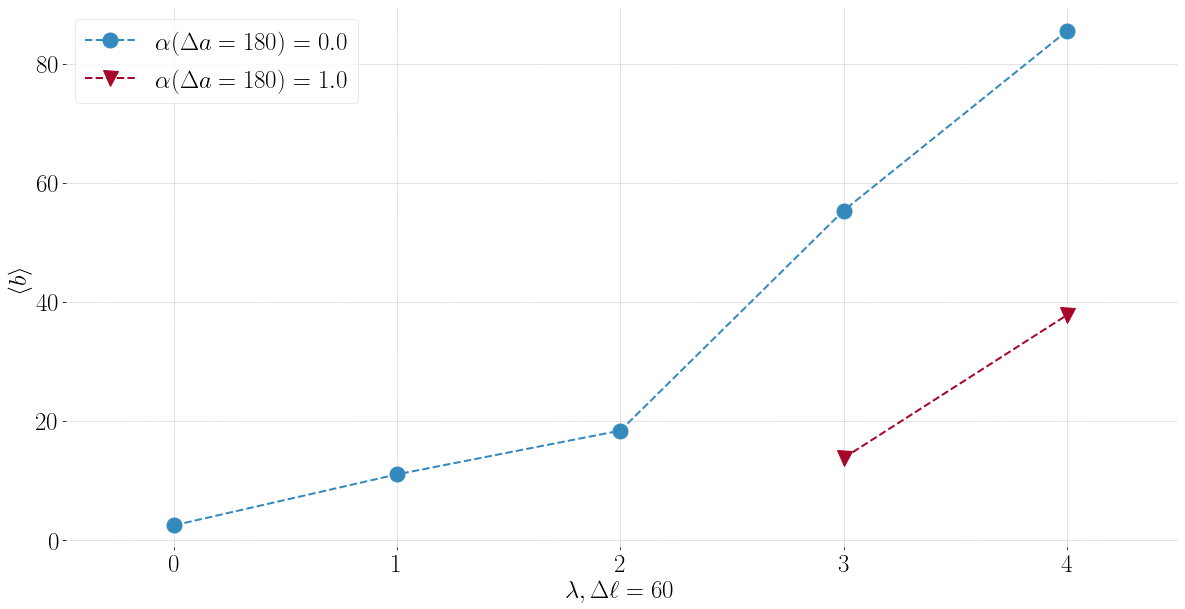

In [9]:
plt.xlabel(r"$\lambda, \Delta \ell = 60$")
plt.ylabel(r"$\langle b \rangle$")
plt.xlim(-0.5, 4.5)
plt.xticks(range(5))
for a in blambplot.keys():
    plt.plot(blambplot[a].index, blambplot[a]['lambda'], marker=markers[int(a)], markersize=15, linestyle="--", label=fr"$\alpha(\Delta a  = 180) = {a}$")
plt.legend()

In [10]:
%time fall2 = pc.get_f(mit_calls, 'all', mit_lives, 60, 180)
%time bal = an.get_b(fall2, 'alpha')
%time balplot = an.plot_g(bal, mit_lives, 'alpha', 180)

CPU times: user 53.7 s, sys: 80.4 ms, total: 53.8 s
Wall time: 53.7 s
CPU times: user 1.47 s, sys: 9.98 ms, total: 1.48 s
Wall time: 1.48 s
CPU times: user 20.8 ms, sys: 13 µs, total: 20.8 ms
Wall time: 20.1 ms


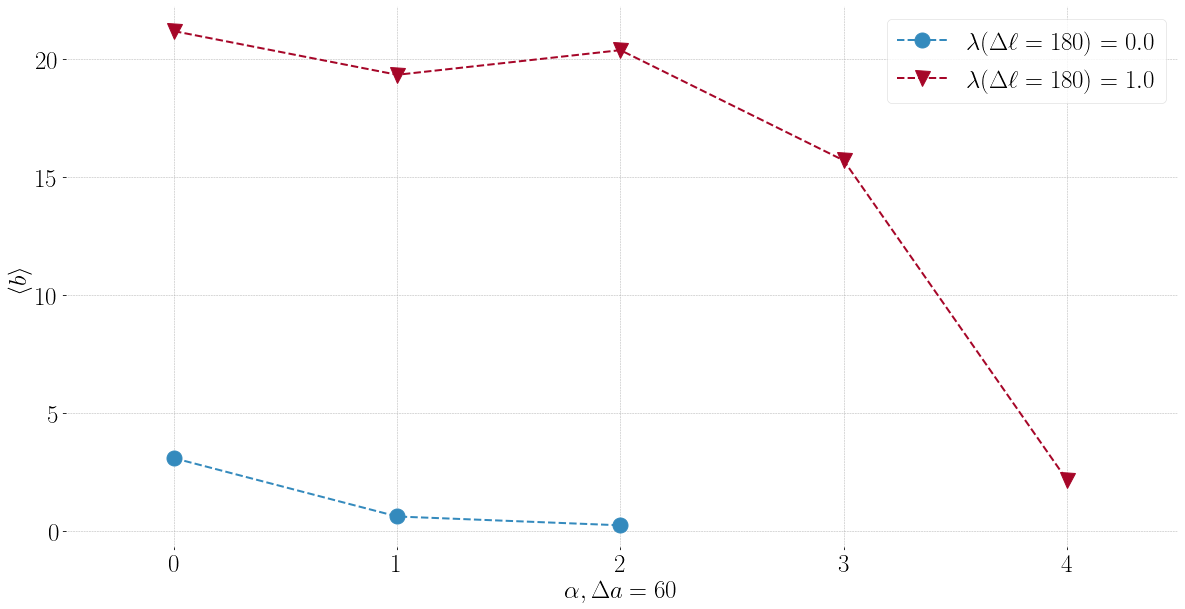

In [11]:
plt.xlabel(r"$\alpha, \Delta a = 60$")
plt.ylabel(r"$\langle b \rangle$")
plt.xlim(-0.5, 4.5)
plt.xticks(range(5))
for a in balplot.keys():
    plt.plot(balplot[a].index, balplot[a]['alpha'], marker=markers[int(a)], markersize=15, linestyle="--", label=fr"$\lambda(\Delta \ell  = 180) = {a}$")
plt.legend()

# Distributions of lifetime separated by $b$

Separated by activity. I will do this as a test using only $b$; but the idea is that evetually I'll use $F$

In [12]:
egolist = list(mit_calls['ego'].unique())

In [14]:
pd.set_option('mode.chained_assignment', None)

In [15]:
%time fall = pc.get_f(mit_calls, 'all', mit_lives, 60, 7)

CPU times: user 55.1 s, sys: 76.7 ms, total: 55.2 s
Wall time: 55.2 s


In [16]:
%time blamb = an.get_b(fall, 'lambda')

CPU times: user 3.1 s, sys: 3.32 ms, total: 3.11 s
Wall time: 3.1 s


In [18]:
allb = []
for ego in blamb.keys():
    df = blamb[ego].loc[blamb[ego]['alpha'] == 1]
    for i in df.index:
        allb.append(df.at[i, 'g'])
        
[max(allb), min(allb), len(allb)]

[360.0, 0.25, 1182]

How to decide on the bins for $b$? For now, I will try to arbitrarily choose based on the distribution.

In [23]:
test = {}
for i in range(4):
    test[i] = {}
    
for ego in blamb.keys():
    df = blamb[ego].loc[blamb[ego]['alpha'] == 1]
    for i in df.index:
        lamb = df.at[i, 'lambda']
        b = df.at[i, 'g']
        test[3][lamb] = test[3].get(lamb, 0) + 1
        if b < 17:
            test[0][lamb] = test[0].get(lamb, 0) + 1
        elif (b >= 17) and (b < 34):
            test[1][lamb] = test[1].get(lamb, 0) + 1
        else:
            test[2][lamb] = test[2].get(lamb, 0) + 1

for i in test.keys():
    test[i] = pd.DataFrame.from_dict(test[i], orient='index')
    test[i].sort_index(inplace=True)

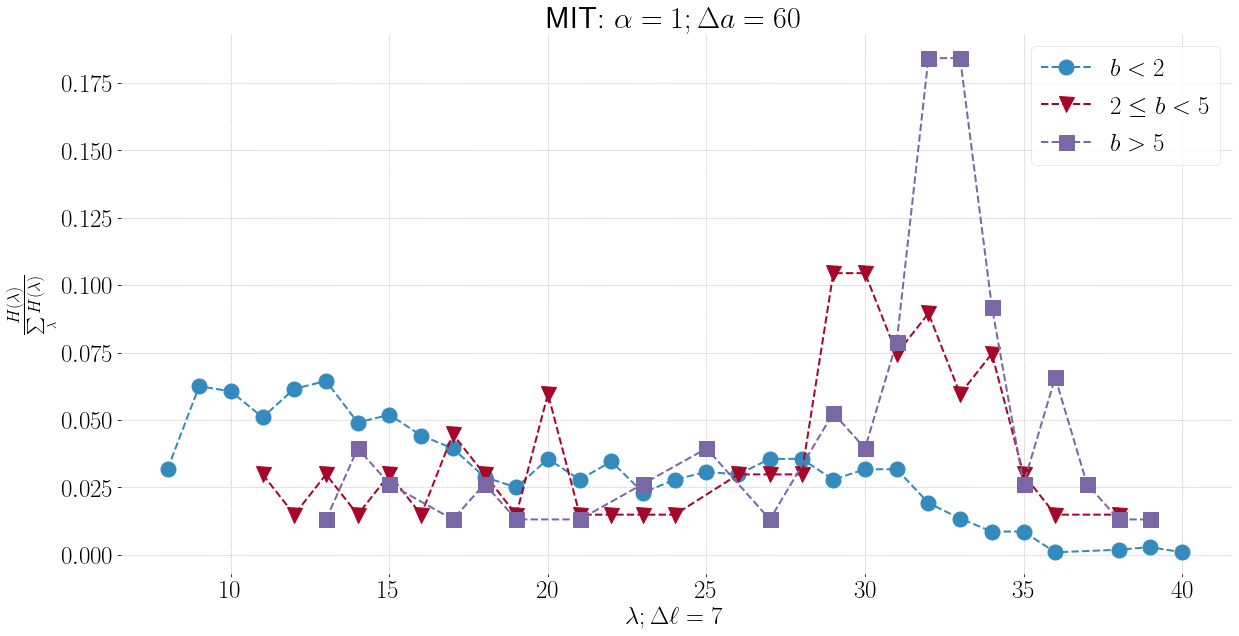

In [24]:
legends = [r"$b < 2$", r"$2 \leq b < 5$", r"$b > 5$", r"All $b$"]
plt.title(r"MIT: $\alpha = 1; \Delta a  = 60$")
plt.xlabel(r"$\lambda; \Delta \ell = 7$")
plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
for i in range(3):
    plt.plot(test[i].index, test[i][0] / sum(test[i][0]), marker=markers[i], linestyle="--", markersize=15, label=legends[i])
plt.legend()

But I could also choose bins of 